In [2]:
%matplotlib inline

import fnmatch
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tqdm import tqdm
import random
from sklearn.decomposition import PCA
import tensorflow as tf

lfw_path = "./dataset"
    
images = []
for root, dirnames, filenames in os.walk(lfw_path):
    for filename in fnmatch.filter(filenames, '*.jpg'):
        images.append(os.path.join(root, filename))

for i, image in tqdm(enumerate(images)):
    if (os.stat(image).st_size < 500):
        del images[i]
        
n = len(images)
print("loaded %d art images" % n)

/home/tait/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
18807it [00:00, 193206.79it/s]

loaded 18807 art images


In [3]:
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

with tf.Session() as sess:
    print (sess.run(c))

[[22. 28.]
 [49. 64.]]


In [ ]:
w = h = 100

X = np.zeros((n, w*h*3))
for i, img in tqdm(enumerate(images)):
    im = Image.open(img)
    width, height = im.size
    left = (width - w)/2
    top = (height - h)/2
    right = (width + w)/2
    bottom = (height + h)/2
    im = im.crop((left, top, right, bottom))
    pixels = im.getdata()
    X[i, :] = np.array(pixels).flatten()


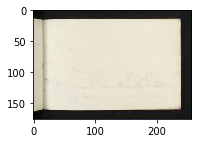

In [6]:
img = [Image.open(images[int(n*random.random())]) for i in range(8)]
plt.figure(figsize=(16,2))
plt.imshow(img[1])

In [8]:
n_components = 100
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True)
pca.fit(X)

print(X.shape)

(18807, 30000)


In [9]:
Xp = pca.transform(X)

print(Xp.shape)

(18807, 100)


In [10]:
Xt = pca.inverse_transform(Xp)
Xt = np.clip(Xt, 0, 255)

print(Xt.shape)

(18807, 30000)


In [11]:
print(X[1].shape)

(30000,)


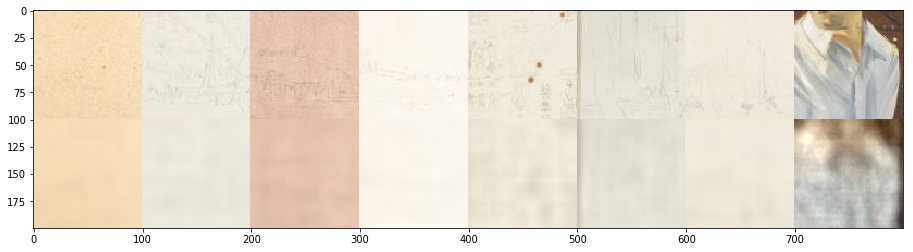

In [12]:
img_pairs = [[X[idx].reshape((w,h,3)), Xt[idx].reshape((w,h,3))] for idx in np.random.randint(n, size=8)]
img_all = np.concatenate([ np.concatenate([p[0], p[1]]) for p in img_pairs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(Image.fromarray(img_all.astype('uint8')))

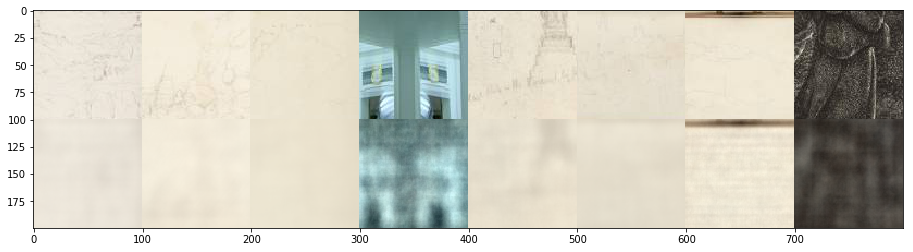

In [13]:
Xt = pca.inverse_transform(Xp)
Xt = np.clip(Xt, 0, 255)
img_pairs = [[X[idx].reshape((w,h, 3)), Xt[idx].reshape((w,h, 3))] for idx in np.random.randint(n, size=8)]
img_all = np.concatenate([ np.concatenate([p[0], p[1]]) for p in img_pairs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(Image.fromarray(img_all.astype('uint8')))

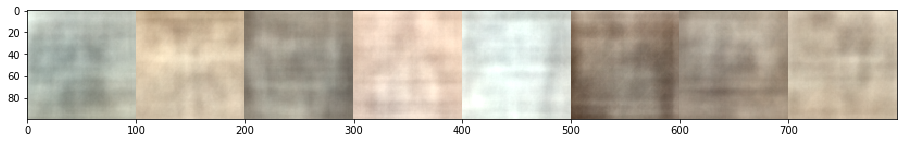

In [15]:
Y = [ np.random.normal(size=n_components) for i in range(8) ] 
Yt = [ np.clip(pca.inverse_transform(y), 0, 255) for y in Y ]
Yt = np.concatenate([ yt.reshape((w,h,3)) for yt in Yt ], axis=1)
plt.figure(figsize=(16,2))
plt.imshow(Image.fromarray(Yt.astype('uint8')))

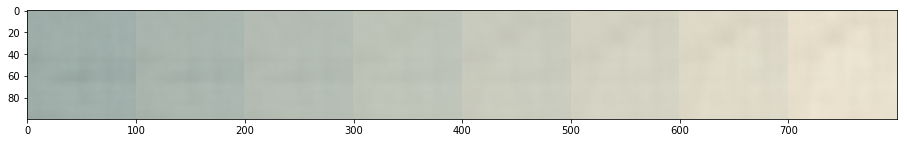

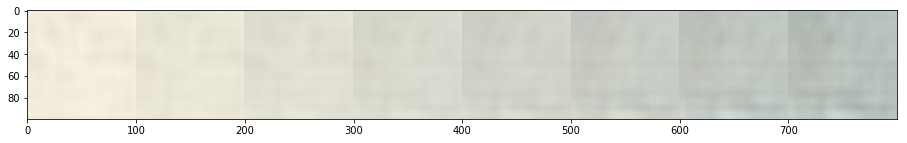

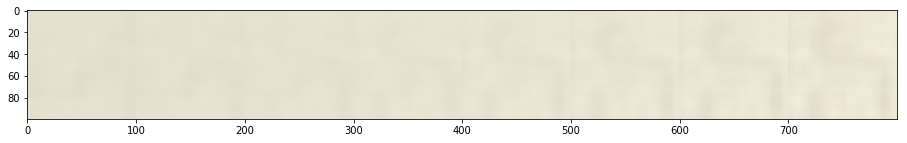

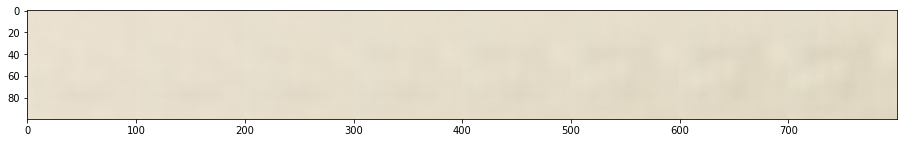

In [16]:
for i in range(4):
    xp1, xp2 = Xp[int(n*random.random())], Xp[int(n*random.random())]
    Z = [[(1.0-r)*i1 + r*i2 for i1, i2 in zip(xp1, xp2)] for r in np.linspace(0,1,8)]
    Y = np.concatenate([ np.clip(pca.inverse_transform(z), 0, 255).reshape((w,h,3)) for z in Z ], axis=1)
    plt.figure(figsize=(16,2))
    plt.imshow(Image.fromarray(Y.astype('uint8')))

In [ ]:
npca = [2000, 1000, 500, 100, 50, 10, 2, 1]
Xt = []
for p in npca:
    print("computing PCA for %d components"%p)
    pca = PCA(n_components=p, svd_solver='randomized', whiten=True)
    pca.fit(X)
    Xp = pca.transform(X)
    Xt.append(np.clip(pca.inverse_transform(Xp), 0, 255))

computing PCA for 2000 components
computing PCA for 1000 components


In [ ]:
idxs = np.random.randint(n, size=4)
for i,idx in enumerate(idxs):
    img_orig = X[idx].reshape((w,h,3))
    img_reconstructed = np.concatenate([Xt[p][idx].reshape((w,h,3)) for p in range(len(npca))], axis=1)
    plt.figure(figsize=(2,2))
    plt.imshow(Image.fromarray(img_orig.astype('uint8')))
    plt.figure(figsize=(16,2))
    plt.imshow(Image.fromarray(img_reconstructed.astype('uint8')))